======= ENHANCED STOCK PREDICTION MODEL =======
Step 1: Loading and preprocessing data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded 3857 days of data
Data shape after preprocessing: (3828, 12)

Step 2: Preparing data for time series modeling...
Training set: 3062 samples
Test set: 766 samples

===== Building model for 1-day prediction =====
Training sequences: (3041, 20, 11)
Testing sequences: (745, 20, 11)
Training model for 1-day...
Epoch 1/50


c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.7631 - mae: 0.6048 - val_loss: 2.0722 - val_mae: 0.8939 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7379 - mae: 0.5903 - val_loss: 2.0792 - val_mae: 0.9030 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7362 - mae: 0.5918 - val_loss: 2.0823 - val_mae: 0.9045 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7367 - mae: 0.5905 - val_loss: 2.0878 - val_mae: 0.9035 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7350 - mae: 0.5904 - val_loss: 2.0955 - val_mae: 0.9114 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7341 - mae: 0.5905 - val_loss: 2.0960 - val_mae: 0.9172 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7283 - mae: 0.5870 - val_loss: 2.1047 - val_mae: 0.9187 - learning_rate: 0.0010
Epoch 8/50
76/76 ━━━━━━━━━━━━━

c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.7190 - mae: 0.5914 - val_loss: 2.1106 - val_mae: 0.9156 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7032 - mae: 0.5819 - val_loss: 2.1142 - val_mae: 0.9217 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6945 - mae: 0.5788 - val_loss: 2.1070 - val_mae: 0.9168 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6972 - mae: 0.5811 - val_loss: 2.0830 - val_mae: 0.8977 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6944 - mae: 0.5769 - val_loss: 2.0836 - val_mae: 0.8996 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6943 - mae: 0.5749 - val_loss: 2.0800 - val_mae: 0.8964 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6945 - mae: 0.5785 - val_loss: 2.0767 - val_mae: 0.8943 - learning_rate: 0.0010
Epoch 8/50
76/76 ━━━━━━━

c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.8252 - mae: 0.6351 - val_loss: 2.0770 - val_mae: 0.8844 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7712 - mae: 0.6103 - val_loss: 2.0742 - val_mae: 0.8843 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7739 - mae: 0.6108 - val_loss: 2.0722 - val_mae: 0.8841 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7707 - mae: 0.6102 - val_loss: 2.0668 - val_mae: 0.8849 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7715 - mae: 0.6101 - val_loss: 2.0703 - val_mae: 0.8850 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7633 - mae: 0.6066 - val_loss: 2.0699 - val_mae: 0.8860 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7610 - mae: 0.6059 - val_loss: 2.0721 - val_mae: 0.8865 - learning_rate: 0.0010
Epoch 8/50
76/76 ━━━━━━━━━━━━

c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6453 - mae: 0.5587 - val_loss: 2.1933 - val_mae: 0.9328 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6228 - mae: 0.5519 - val_loss: 2.1937 - val_mae: 0.9327 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6160 - mae: 0.5467 - val_loss: 2.1966 - val_mae: 0.9324 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6122 - mae: 0.5446 - val_loss: 2.1964 - val_mae: 0.9325 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6129 - mae: 0.5443 - val_loss: 2.1997 - val_mae: 0.9328 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6120 - mae: 0.5456 - val_loss: 2.1995 - val_mae: 0.9331 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6147 - mae: 0.5467 - val_loss: 2.2008 - val_mae: 0.9332 - learning_rate: 0.0010
Epoch 8/50
70/70 ━━━━━━━━

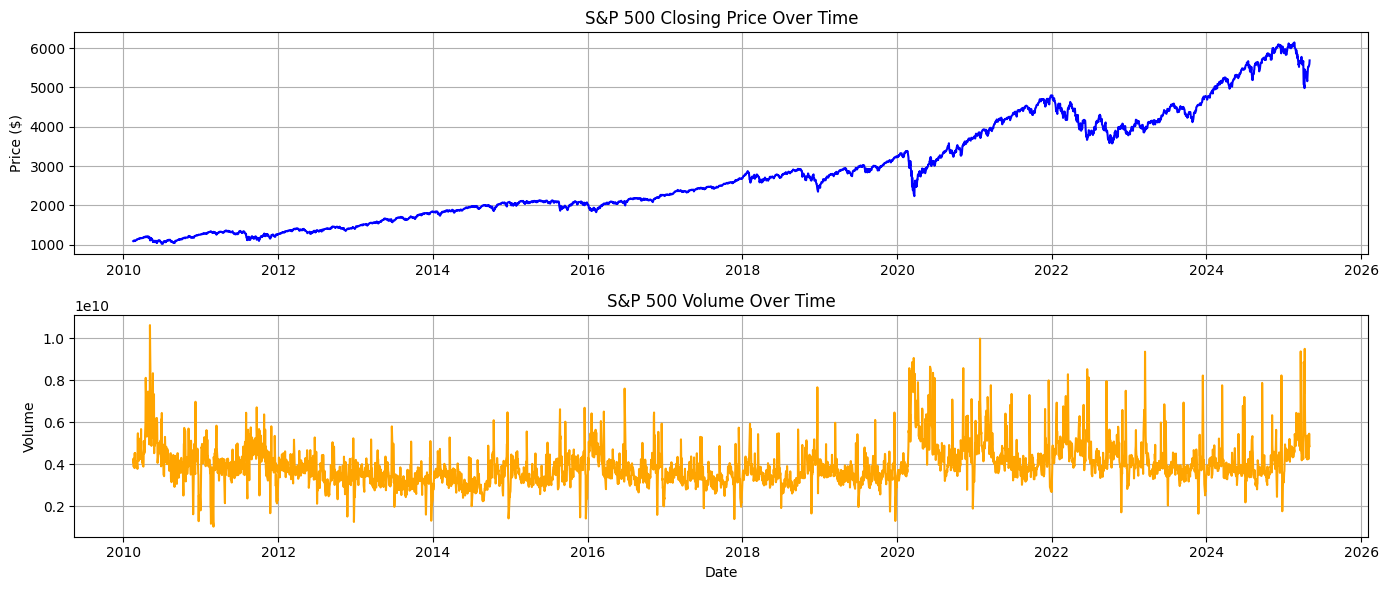

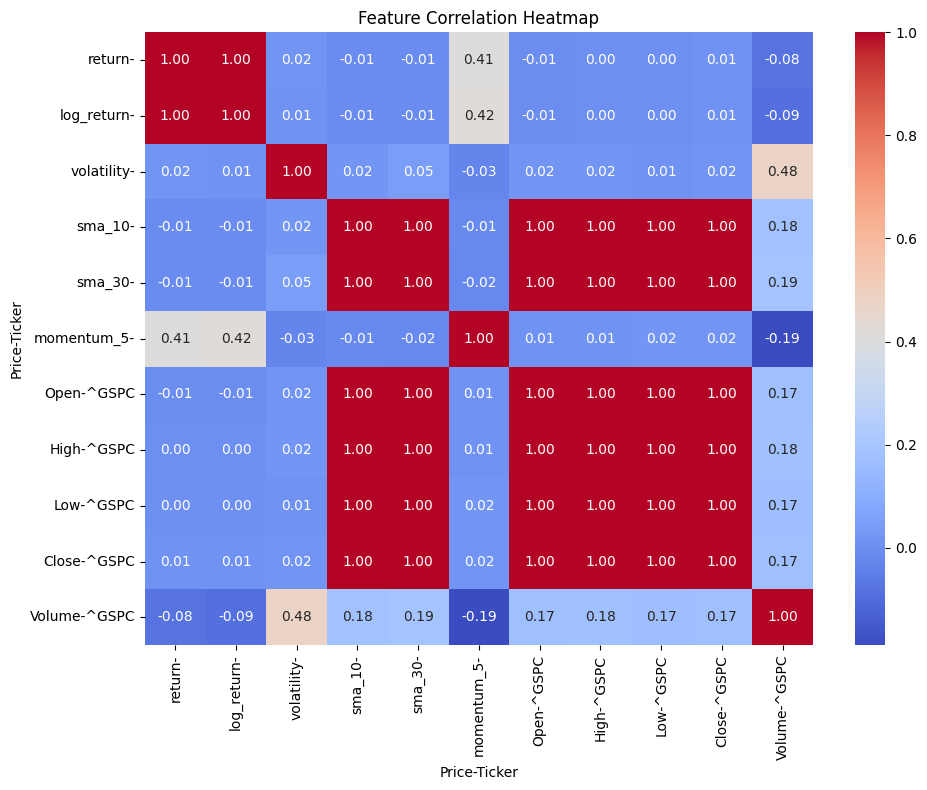

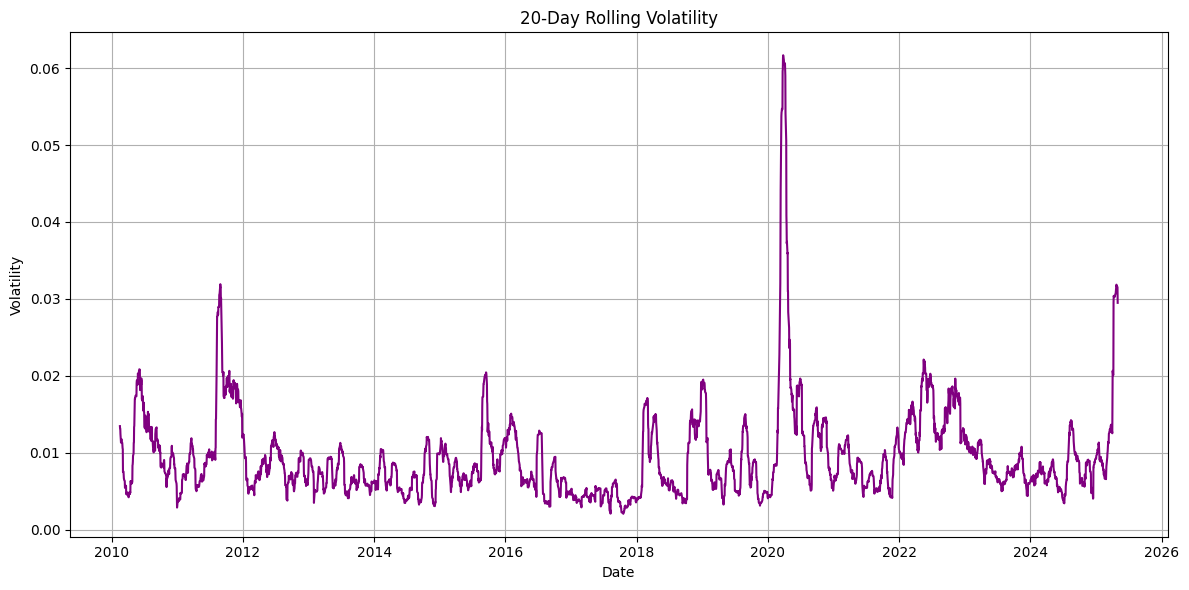

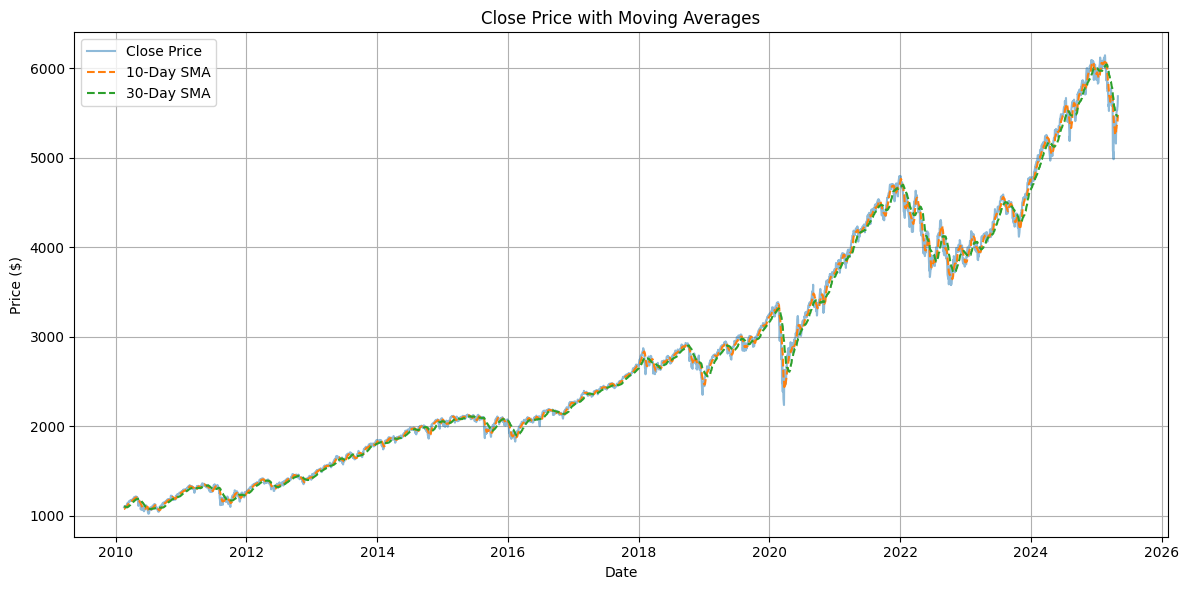

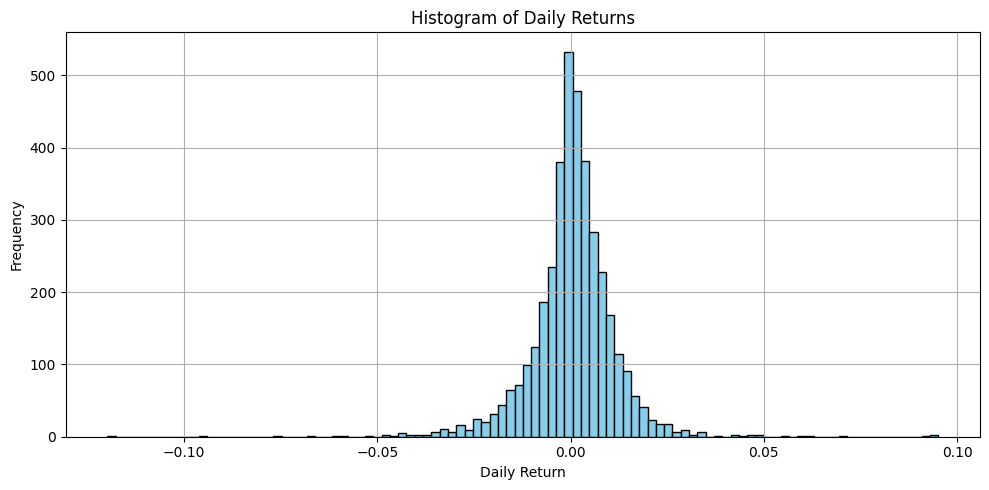

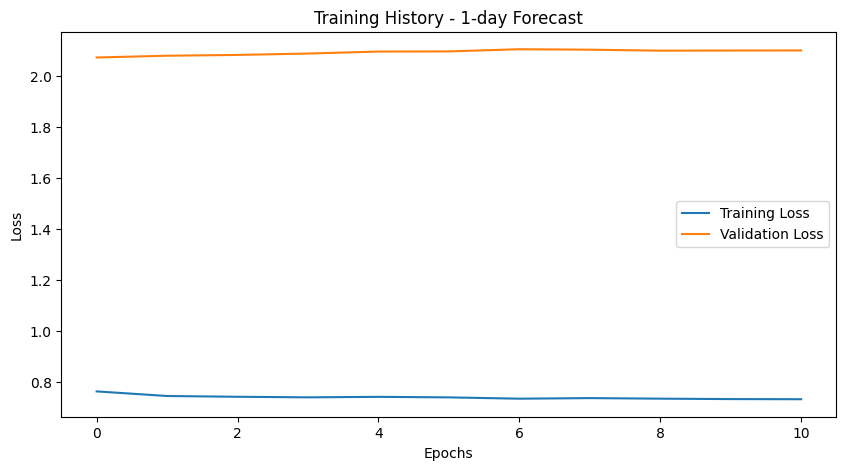

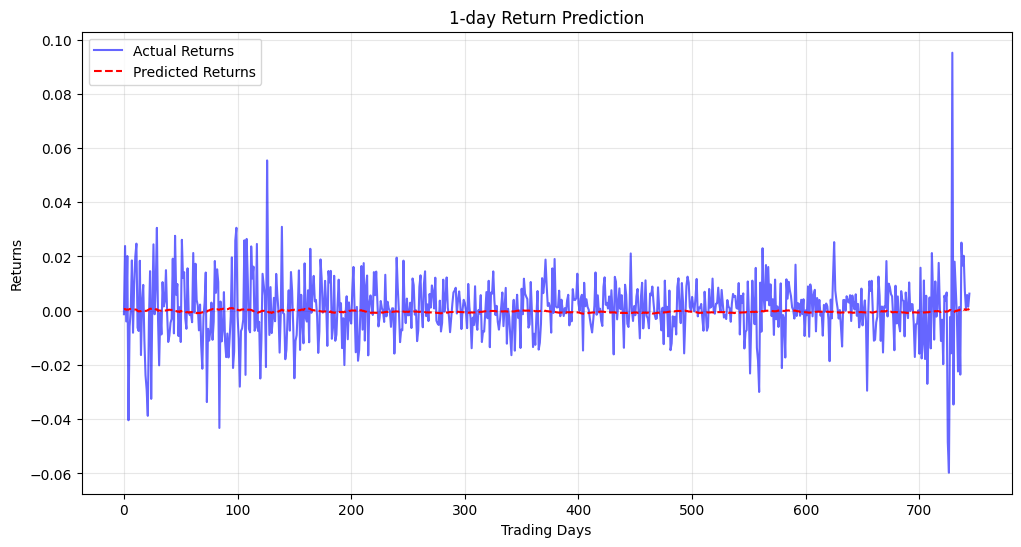

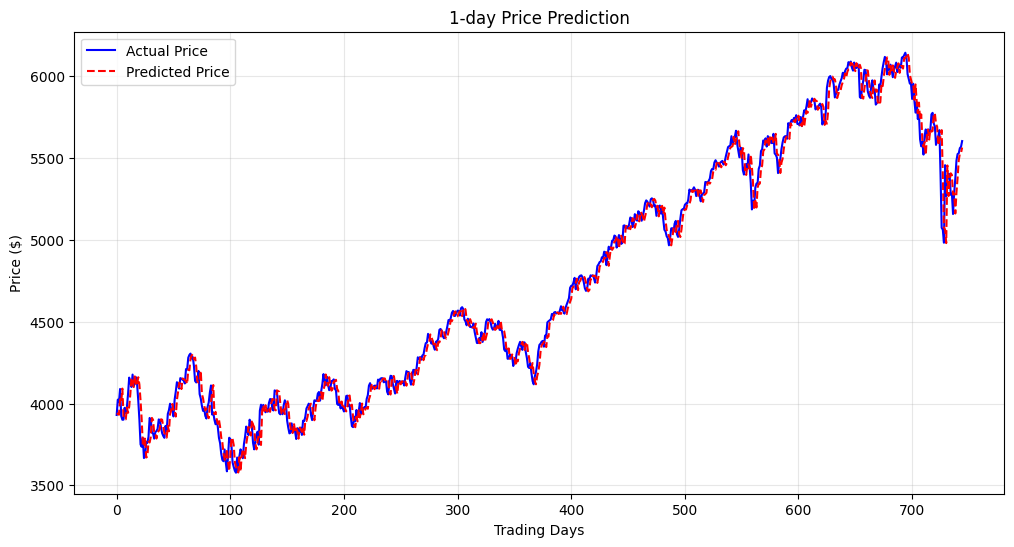

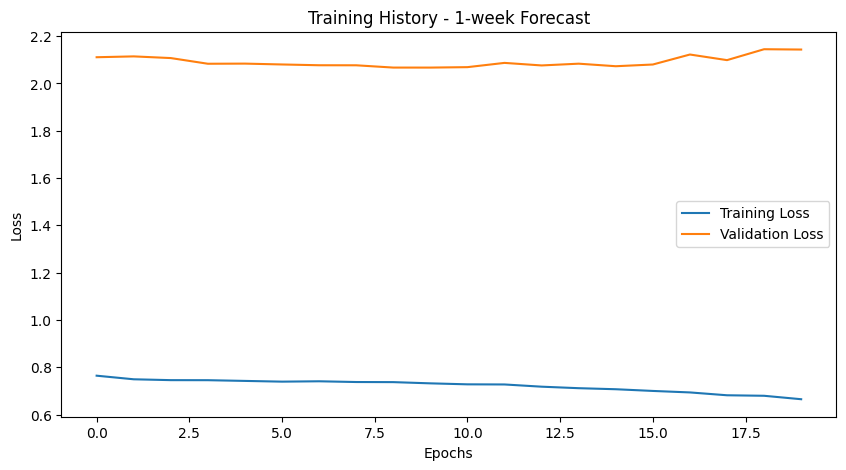

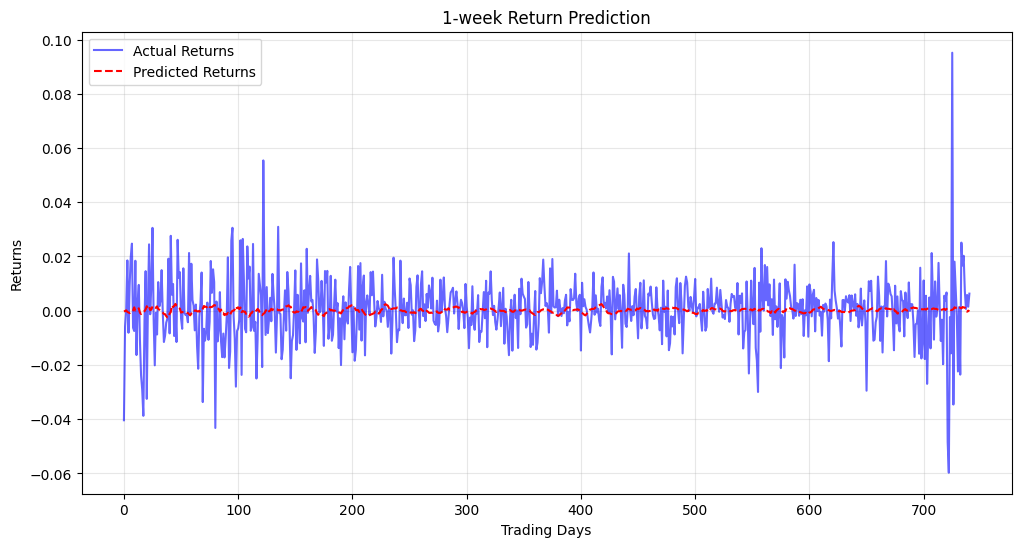

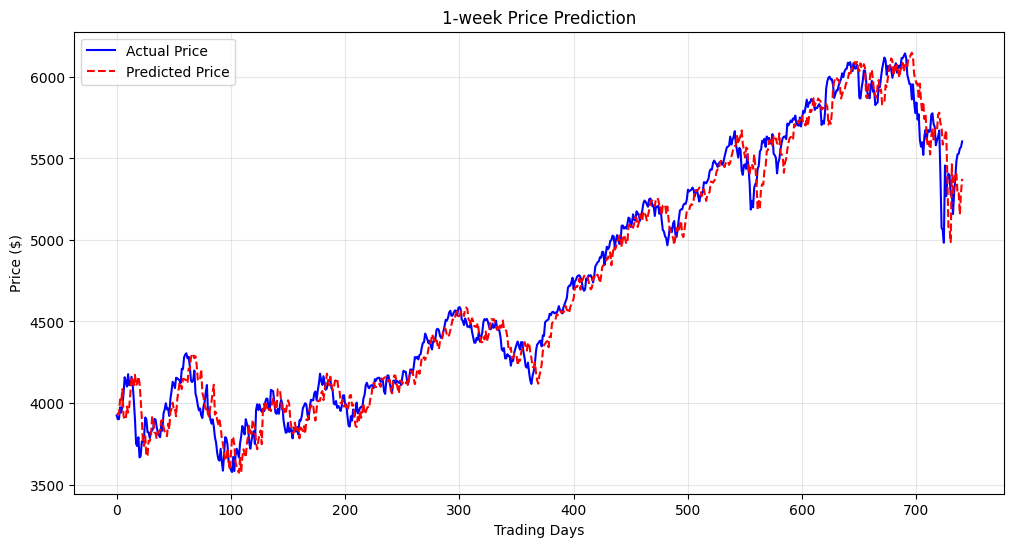

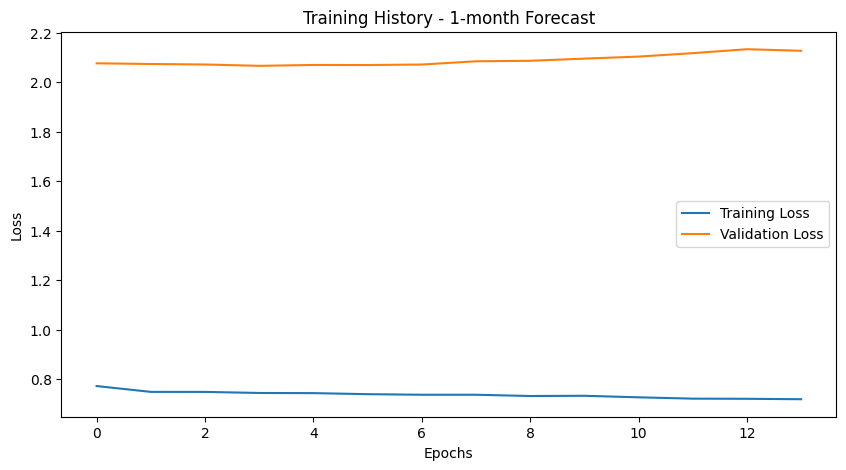

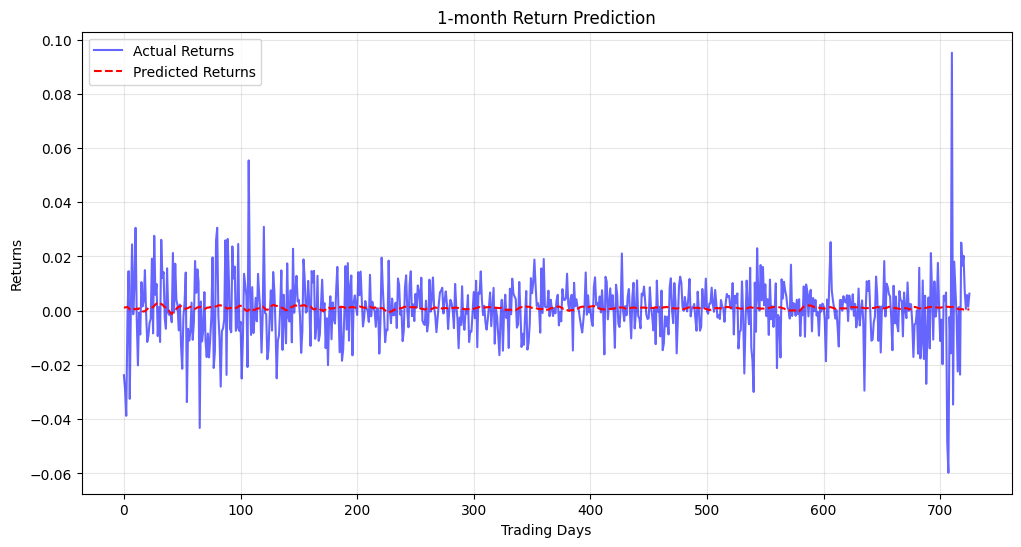

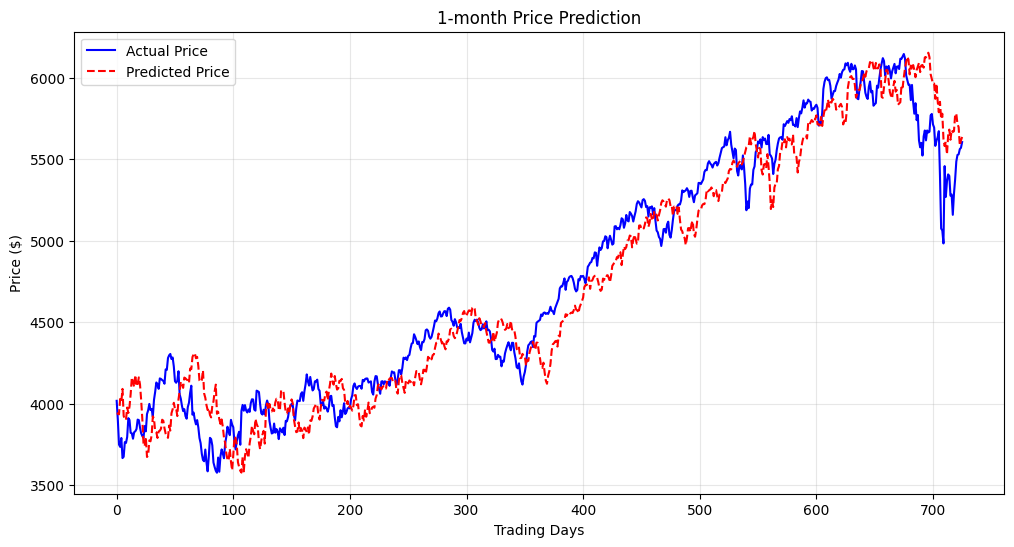

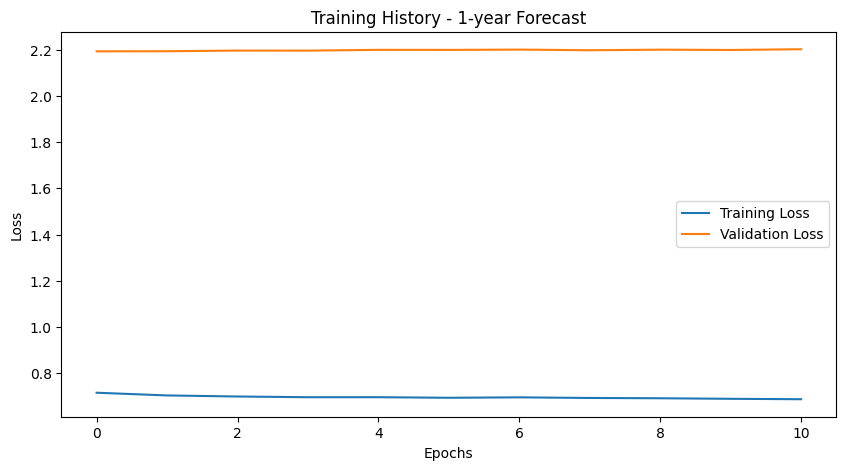

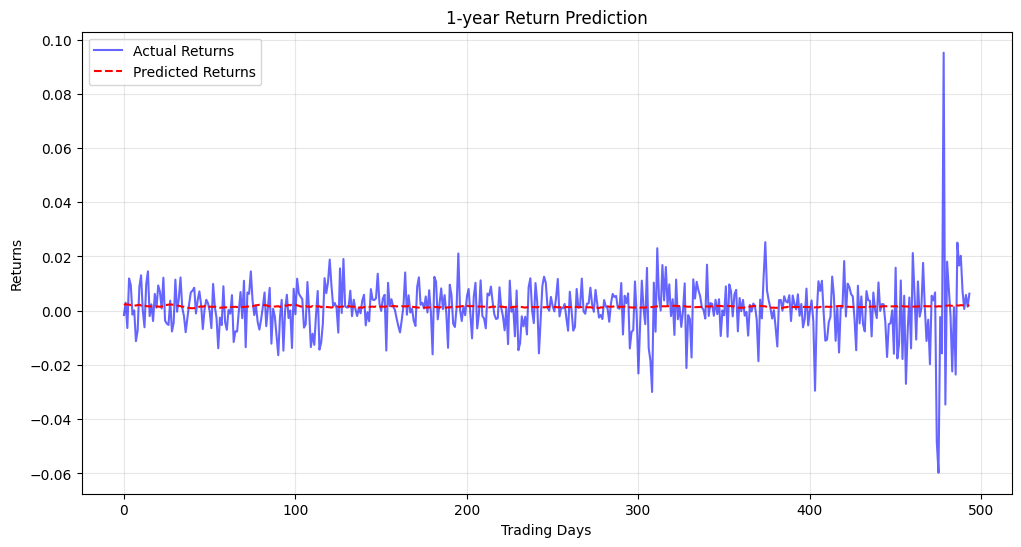

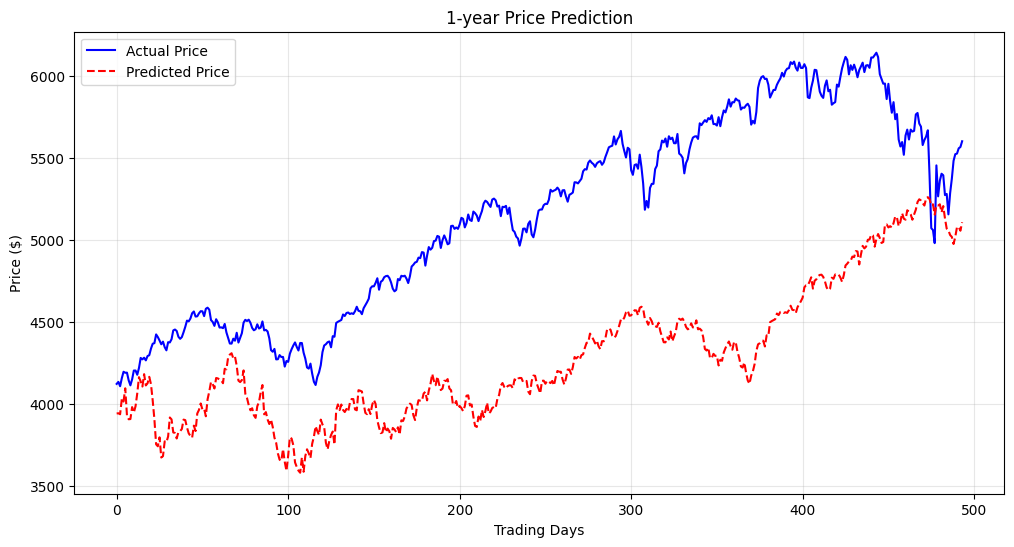

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import time
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
model_dir = "stock_models_enhanced"
os.makedirs(model_dir, exist_ok=True)

print("======= ENHANCED STOCK PREDICTION MODEL =======")
print("Step 1: Loading and preprocessing data...")

# Load stock data
try:
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.today()
    
    # Download data with retry mechanism
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            df = yf.download(tickers=['^GSPC'], start=start, end=end)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"Attempt {attempt+1} failed. Retrying...")
                time.sleep(2)
            else:
                raise Exception(f"Failed to download data after {max_attempts} attempts: {e}")
    
    if df.empty:
        raise Exception("Downloaded dataframe is empty")
    
    print(f"Successfully downloaded {len(df)} days of data")
    
    # Basic preprocessing
    df = df.dropna().reset_index()
    
    # Calculate returns instead of using raw prices
    df['return'] = df['Close'].pct_change()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Calculate volatility (20-day rolling standard deviation)
    df['volatility'] = df['log_return'].rolling(window=20).std()
    
    # Calculate moving averages
    df['sma_10'] = df['Close'].rolling(window=10).mean()
    df['sma_30'] = df['Close'].rolling(window=30).mean()
    
    # Calculate price momentum (rate of change)
    df['momentum_5'] = df['Close'].pct_change(periods=5)
    
    # Drop NaN values
    df = df.dropna().reset_index(drop=True)
    # 1. Close Price and Volume Over Time
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    plt.title('S&P 500 Closing Price Over Time')
    plt.ylabel('Price ($)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], df['Volume'], label='Volume', color='orange')
    plt.title('S&P 500 Volume Over Time')
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'price_volume_time_series.png'))

    # 2. Feature Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'feature_correlation_heatmap.png'))

    # 3. Rolling Volatility
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['volatility'], color='purple')
    plt.title('20-Day Rolling Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'rolling_volatility.png'))

    # 4. Moving Averages
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.5)
    plt.plot(df['Date'], df['sma_10'], label='10-Day SMA', linestyle='--')
    plt.plot(df['Date'], df['sma_30'], label='30-Day SMA', linestyle='--')
    plt.title('Close Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'moving_averages.png'))

    # 5. Histogram of Daily Returns
    plt.figure(figsize=(10, 5))
    plt.hist(df['return'], bins=100, color='skyblue', edgecolor='black')
    plt.title('Histogram of Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'return_distribution.png'))
    print(f"Data shape after preprocessing: {df.shape}")
    
except Exception as e:
    print(f"Error in data loading: {e}")
    exit(1)

print("\nStep 2: Preparing data for time series modeling...")

try:
    # Focus on predicting returns instead of absolute prices
    # This makes the prediction task more realistic and normalizes the target variable
    target_variable = 'return'
    
    # Select a reasonable set of features
    features = ['return', 'log_return', 'volatility', 
                'sma_10', 'sma_30', 'momentum_5',
                'Open', 'High', 'Low', 'Close', 'Volume']
    
    # Separate test set (last 20% of data)
    test_split = int(len(df) * 0.8)
    train_df = df.iloc[:test_split].copy()
    test_df = df.iloc[test_split:].copy()
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Function to create sequences - specialized for each prediction horizon
    def create_sequences(data, features, target_col, seq_length, horizon):
        X, y = [], []
        feature_data = data[features].values
        target_data = data[target_col].values
        
        for i in range(seq_length, len(data) - horizon):
            X.append(feature_data[i-seq_length:i])
            # Target is the return value 'horizon' days ahead
            y.append(target_data[i + horizon - 1])
            
        return np.array(X), np.array(y)
    
except Exception as e:
    print(f"Error in data preparation: {e}")
    exit(1)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure the learning rate is a float
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the learning rate is a float

def build_model_for_horizon(horizon, horizon_name):
    print(f"\n===== Building model for {horizon_name} prediction =====")
    
    try:
        # Parameters
        sequence_length = 20  # Use 20 days of data to predict
        
        # Create scaled datasets - scale each feature independently
        scaler_dict = {}
        scaled_train_data = train_df[features].copy()
        scaled_test_data = test_df[features].copy()
        
        for feature in features:
            scaler = StandardScaler()
            scaled_train_data[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1, 1))
            scaled_test_data[feature] = scaler.transform(test_df[feature].values.reshape(-1, 1))
            scaler_dict[feature] = scaler
            
        # Store target scaler for inverse transformation later
        target_scaler = scaler_dict[target_variable]
            
        # Create sequences
        X_train, y_train = create_sequences(
            scaled_train_data, features, target_variable, sequence_length, horizon
        )
        
        X_test, y_test = create_sequences(
            scaled_test_data, features, target_variable, sequence_length, horizon
        )
        
        print(f"Training sequences: {X_train.shape}")
        print(f"Testing sequences: {X_test.shape}")
        
        # Build an enhanced model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(30, activation='tanh', recurrent_activation='sigmoid')),
            Dropout(0.2),
            Dense(1)
        ])
        
        # Compile with appropriate loss for returns prediction
        initial_learning_rate = 0.001
        optimizer = Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint(
                filepath=os.path.join(model_dir, f'model_{horizon_name.replace(" ", "_")}.keras'),
                monitor='val_loss', save_best_only=True
            ),
            LearningRateScheduler(lr_scheduler)
        ]
        
        # Train the model
        print(f"Training model for {horizon_name}...")
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History - {horizon_name} Forecast')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(model_dir, f'training_history_{horizon_name.replace(" ", "_")}.png'))
        
        # Evaluate the model
        print(f"\nEvaluating {horizon_name} forecast model...")
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Convert predictions back to original scale
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_orig = target_scaler.inverse_transform(y_pred).flatten()
        
        # Calculate metrics on original scale data
        mse = mean_squared_error(y_test_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        r2 = r2_score(y_test_orig, y_pred_orig)
        
        # Calculate MAPE carefully to handle zeros or near-zeros
        mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.maximum(np.abs(y_test_orig), 1e-7))) * 100
        
        print(f"\n🔹 {horizon_name} Forecast Metrics:")
        print(f"   • Mean Squared Error (MSE): {mse:.6f}")
        print(f"   • Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"   • Mean Absolute Error (MAE): {mae:.6f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"   • R² Score: {r2:.4f}")
        
        # Plot predictions vs actual returns
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_orig, label='Actual Returns', color='blue', alpha=0.6)
        plt.plot(y_pred_orig, label='Predicted Returns', color='red', linestyle='--')
        plt.title(f'{horizon_name} Return Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'returns_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # Convert returns to actual price predictions
        last_prices = []
        predicted_prices = []
        actual_prices = []
        
        # Get price information
        test_prices = test_df['Close'].values
        
        for i in range(len(y_test_orig)):
            idx = i + sequence_length + horizon - 1
            if idx < len(test_prices):
                # For the first point, use the actual price as base
                if i == 0:
                    prev_price = test_prices[sequence_length - 1]
                else:
                    prev_price = test_prices[sequence_length + i - 2]
                
                # Actual price
                actual_price = test_prices[idx]
                
                # Predicted price based on return prediction
                predicted_return = y_pred_orig[i]
                predicted_price = prev_price * (1 + predicted_return)
                
                last_prices.append(prev_price)
                predicted_prices.append(predicted_price)
                actual_prices.append(actual_price)
        
        # Plot price predictions
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices, label='Actual Price', color='blue')
        plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{horizon_name} Price Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'price_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # Calculate price prediction metrics
        price_mse = mean_squared_error(actual_prices, predicted_prices)
        price_rmse = np.sqrt(price_mse)
        price_mae = mean_absolute_error(actual_prices, predicted_prices)
        price_mape = np.mean(np.abs((np.array(actual_prices) - np.array(predicted_prices)) / np.array(actual_prices))) * 100
        price_r2 = r2_score(actual_prices, predicted_prices)
        
        print(f"\n🔹 {horizon_name} Price Prediction Metrics:")
        print(f"   • Mean Squared Error (MSE): {price_mse:.4f}")
        print(f"   • Root Mean Squared Error (RMSE): {price_rmse:.4f}")
        print(f"   • Mean Absolute Error (MAE): {price_mae:.4f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {price_mape:.2f}%")
        print(f"   • R² Score: {price_r2:.4f}")
        
        # Make future prediction
        last_sequence = scaled_test_data[features].values[-sequence_length:]
        last_sequence = last_sequence.reshape(1, sequence_length, len(features))
        predicted_return = model.predict(last_sequence)[0][0]
        
        # Convert to original scale
        predicted_return_orig = target_scaler.inverse_transform([[predicted_return]])[0][0]
        
        # Get the latest price
        latest_price = df['Close'].iloc[-1]
        
        # Calculate predicted price
        predicted_price = latest_price * (1 + predicted_return_orig)
        
        print(f"\n🔹 Future {horizon_name} Prediction:")
        print(f"   • Current Price: ${latest_price:.2f}")
        print(f"   • Predicted {horizon_name} Return: {predicted_return_orig*100:.2f}%")
        print(f"   • Predicted {horizon_name} Price: ${predicted_price:.2f}")
        
        # Return key metrics for comparison
        return {
            'horizon': horizon_name,
            'return_r2': r2,
            'price_r2': price_r2,
            'price_mape': price_mape,
            'model': model
        }
        
    except Exception as e:
        print(f"Error in {horizon_name} model: {e}")
        return None
# Train models for different prediction horizons
horizons = [
    (1, "1-day"),
    (5, "1-week"),
    (20, "1-month"),
    (252, "1-year")
]

results = []
for horizon_days, horizon_name in horizons:
    result = build_model_for_horizon(horizon_days, horizon_name)
    if result:
        results.append(result)

# Compare model performance across horizons
if results:
    print("\n===== MODEL COMPARISON =====")
    for result in results:
        print(f"🔹 {result['horizon']}:")
        print(f"   • Return Prediction R²: {result['return_r2']:.4f}")
        print(f"   • Price Prediction R²: {result['price_r2']:.4f}")
        print(f"   • Price Prediction MAPE: {result['price_mape']:.2f}%")

print("\nModel training and evaluation complete. Check the 'stock_models_enhanced' directory for outputs.")


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import time
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
model_dir = "stock_models_enhanced"
os.makedirs(model_dir, exist_ok=True)

print("======= ENHANCED STOCK PREDICTION MODEL =======")
print("Step 1: Loading and preprocessing data...")

# Load stock data
try:
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.today()
    
    # Download data with retry mechanism
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            df = yf.download(tickers=['^GSPC'], start=start, end=end)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"Attempt {attempt+1} failed. Retrying...")
                time.sleep(2)
            else:
                raise Exception(f"Failed to download data after {max_attempts} attempts: {e}")
    
    if df.empty:
        raise Exception("Downloaded dataframe is empty")
    
    print(f"Successfully downloaded {len(df)} days of data")
    
    # Basic preprocessing
    df = df.dropna().reset_index()
    
    # Calculate returns instead of using raw prices
    df['return'] = df['Close'].pct_change()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Calculate volatility (20-day rolling standard deviation)
    df['volatility'] = df['log_return'].rolling(window=20).std()
    
    # Calculate moving averages
    df['sma_10'] = df['Close'].rolling(window=10).mean()
    df['sma_30'] = df['Close'].rolling(window=30).mean()
    df['sma_200'] = df['Close'].rolling(window=200).mean()  # Added longer-term moving average
    
    # Calculate price momentum (rate of change)
    df['momentum_5'] = df['Close'].pct_change(periods=5)
    df['momentum_60'] = df['Close'].pct_change(periods=60)  # Added longer-term momentum
    
    # Yearly seasonality indicators (could be useful for long-term predictions)
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
    
    # Create month and quarter dummies for seasonality
    month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
    quarter_dummies = pd.get_dummies(df['quarter'], prefix='quarter', drop_first=True)
    df = pd.concat([df, month_dummies, quarter_dummies], axis=1)
    
    # Drop NaN values after creating all features
    df = df.dropna().reset_index(drop=True)
    
    print(f"Data shape after preprocessing: {df.shape}")
    
except Exception as e:
    print(f"Error in data loading: {e}")
    exit(1)

print("\nStep 2: Preparing data for time series modeling...")

try:
    # Focus on predicting returns instead of absolute prices
    target_variable = 'return'
    
    # Select a reasonable set of features
    base_features = ['return', 'log_return', 'volatility', 
                'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60',
                'Open', 'High', 'Low', 'Close', 'Volume']
    
    # Add seasonality features
    seasonality_features = []
    for col in df.columns:
        if isinstance(col, str) and (col.startswith('month_') or col.startswith('quarter_')):
            seasonality_features.append(col)
    
    # Combine all features
    features = base_features + seasonality_features
    
    # Separate test set (last 20% of data)
    test_split = int(len(df) * 0.8)
    train_df = df.iloc[:test_split].copy()
    test_df = df.iloc[test_split:].copy()
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Function to create sequences - specialized for each prediction horizon
    def create_sequences(data, features, target_col, seq_length, horizon):
        X, y = [], []
        feature_data = data[features].values
        target_data = data[target_col].values
        
        for i in range(seq_length, len(data) - horizon):
            X.append(feature_data[i-seq_length:i])
            # Target is the return value 'horizon' days ahead
            y.append(target_data[i + horizon - 1])
            
        return np.array(X), np.array(y)
    
except Exception as e:
    print(f"Error in data preparation: {e}")
    import traceback
    traceback.print_exc()
    exit(1)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure the learning rate is a float
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the learning rate is a float

def build_model_for_horizon(horizon, horizon_name):
    print(f"\n===== Building model for {horizon_name} prediction =====")
    
    try:
        # Parameters
        sequence_length = 50 if horizon > 100 else 20  # Use longer sequence for long horizons
        
        # Create scaled datasets - scale each feature independently
        scaler_dict = {}
        scaled_train_data = train_df[features].copy()
        scaled_test_data = test_df[features].copy()
        
        for feature in features:
            scaler = StandardScaler()
            scaled_train_data[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1, 1))
            scaled_test_data[feature] = scaler.transform(test_df[feature].values.reshape(-1, 1))
            scaler_dict[feature] = scaler
            
        # Store target scaler for inverse transformation later
        target_scaler = scaler_dict[target_variable]
            
        # Create sequences
        X_train, y_train = create_sequences(
            scaled_train_data, features, target_variable, sequence_length, horizon
        )
        
        X_test, y_test = create_sequences(
            scaled_test_data, features, target_variable, sequence_length, horizon
        )
        
        print(f"Training sequences: {X_train.shape}")
        print(f"Testing sequences: {X_test.shape}")
        
        # Build an enhanced model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(30, activation='tanh', recurrent_activation='sigmoid')),
            Dropout(0.2),
            Dense(1)
        ])
        
        # Compile with appropriate loss for returns prediction
        initial_learning_rate = 0.001
        optimizer = Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ModelCheckpoint(
                filepath=os.path.join(model_dir, f'model_{horizon_name.replace(" ", "_")}.keras'),
                monitor='val_loss', save_best_only=True
            ),
            LearningRateScheduler(lr_scheduler)
        ]
        
        # Train the model
        print(f"Training model for {horizon_name}...")
        history = model.fit(
            X_train, y_train,
            epochs=100 if horizon > 100 else 50,  # More epochs for longer horizons
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History - {horizon_name} Forecast')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(model_dir, f'training_history_{horizon_name.replace(" ", "_")}.png'))
        
        # Evaluate the model
        print(f"\nEvaluating {horizon_name} forecast model...")
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Convert predictions back to original scale
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_orig = target_scaler.inverse_transform(y_pred).flatten()
        
        # Calculate metrics on original scale data
        mse = mean_squared_error(y_test_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        r2 = r2_score(y_test_orig, y_pred_orig)
        
        # Calculate MAPE carefully to handle zeros or near-zeros
        mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.maximum(np.abs(y_test_orig), 1e-7))) * 100
        
        print(f"\n🔹 {horizon_name} Forecast Metrics:")
        print(f"   • Mean Squared Error (MSE): {mse:.6f}")
        print(f"   • Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"   • Mean Absolute Error (MAE): {mae:.6f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"   • R² Score: {r2:.4f}")
        
        # Plot predictions vs actual returns
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_orig, label='Actual Returns', color='blue', alpha=0.6)
        plt.plot(y_pred_orig, label='Predicted Returns', color='red', linestyle='--')
        plt.title(f'{horizon_name} Return Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'returns_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # For long horizons (like 1 year), we need to calculate compounded returns
        # since we're predicting a single step return after X days
        
        # Calculate cumulative returns for long-term horizons
        if horizon > 20:  # For horizons longer than a month
            # Calculate cumulative returns for the test set
            test_start_price = test_df['Close'].iloc[sequence_length - 1]
            cumulative_returns_actual = []
            cumulative_returns_pred = []
            
            for i in range(min(len(y_test_orig), len(y_pred_orig))):
                actual_return = y_test_orig[i]
                pred_return = y_pred_orig[i]
                
                actual_cumulative = (1 + actual_return) - 1
                pred_cumulative = (1 + pred_return) - 1
                
                cumulative_returns_actual.append(actual_cumulative)
                cumulative_returns_pred.append(pred_cumulative)
            
            # Plot cumulative returns
            plt.figure(figsize=(12, 6))
            plt.plot(cumulative_returns_actual, label='Actual Cumulative Return', color='blue')
            plt.plot(cumulative_returns_pred, label='Predicted Cumulative Return', color='red', linestyle='--')
            plt.title(f'{horizon_name} Cumulative Return Prediction')
            plt.xlabel('Trading Periods')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(model_dir, f'cumulative_returns_{horizon_name.replace(" ", "_")}.png'))
        
        # Convert returns to actual price predictions
        last_prices = []
        predicted_prices = []
        actual_prices = []
        
        # Get price information
        test_prices = test_df['Close'].values
        
        for i in range(len(y_test_orig)):
            idx = i + sequence_length + horizon - 1
            if idx < len(test_prices):
                # For the first point, use the actual price as base
                if i == 0:
                    prev_price = test_prices[sequence_length - 1]
                else:
                    prev_price = test_prices[sequence_length + i - 2]
                
                # Actual price
                actual_price = test_prices[idx]
                
                # Predicted price based on return prediction
                predicted_return = y_pred_orig[i]
                predicted_price = prev_price * (1 + predicted_return)
                
                last_prices.append(prev_price)
                predicted_prices.append(predicted_price)
                actual_prices.append(actual_price)
        
        # Plot price predictions
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices, label='Actual Price', color='blue')
        plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{horizon_name} Price Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'price_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # Calculate price prediction metrics
        price_mse = mean_squared_error(actual_prices, predicted_prices)
        price_rmse = np.sqrt(price_mse)
        price_mae = mean_absolute_error(actual_prices, predicted_prices)
        price_mape = np.mean(np.abs((np.array(actual_prices) - np.array(predicted_prices)) / np.array(actual_prices))) * 100
        price_r2 = r2_score(actual_prices, predicted_prices)
        
        print(f"\n🔹 {horizon_name} Price Prediction Metrics:")
        print(f"   • Mean Squared Error (MSE): {price_mse:.4f}")
        print(f"   • Root Mean Squared Error (RMSE): {price_rmse:.4f}")
        print(f"   • Mean Absolute Error (MAE): {price_mae:.4f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {price_mape:.2f}%")
        print(f"   • R² Score: {price_r2:.4f}")
        
        # Make future prediction
        last_sequence = scaled_test_data[features].values[-sequence_length:]
        last_sequence = last_sequence.reshape(1, sequence_length, len(features))
        predicted_return = model.predict(last_sequence)[0][0]
        
        # Convert to original scale
        predicted_return_orig = target_scaler.inverse_transform([[predicted_return]])[0][0]
        
        # Get the latest price
        latest_price = df['Close'].iloc[-1]
        
        # Calculate predicted price
        predicted_price = latest_price * (1 + predicted_return_orig)
        
        print(f"\n🔹 Future {horizon_name} Prediction:")
        print(f"   • Current Price: ${latest_price:.2f}")
        print(f"   • Predicted {horizon_name} Return: {predicted_return_orig*100:.2f}%")
        print(f"   • Predicted {horizon_name} Price: ${predicted_price:.2f}")
        
        # Return key metrics for comparison
        return {
            'horizon': horizon_name,
            'return_r2': r2,
            'price_r2': price_r2,
            'price_mape': price_mape,
            'model': model
        }
        
    except Exception as e:
        print(f"Error in {horizon_name} model: {e}")
        import traceback
        traceback.print_exc()
        return None
        
# Train models for different prediction horizons
horizons = [
    (1, "1-day"),
    (5, "1-week"),
    (20, "1-month"),
    (252, "1-year")  # Added 1-year prediction (approximately 252 trading days)
]

results = []
for horizon_days, horizon_name in horizons:
    result = build_model_for_horizon(horizon_days, horizon_name)
    if result:
        results.append(result)

# Compare model performance across horizons
if results:
    print("\n===== MODEL COMPARISON =====")
    for result in results:
        print(f"🔹 {result['horizon']}:")
        print(f"   • Return Prediction R²: {result['return_r2']:.4f}")
        print(f"   • Price Prediction R²: {result['price_r2']:.4f}")
        print(f"   • Price Prediction MAPE: {result['price_mape']:.2f}%")

print("\nModel training and evaluation complete. Check the 'stock_models_enhanced' directory for outputs.")

======= ENHANCED STOCK PREDICTION MODEL =======
Step 1: Loading and preprocessing data...


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 3857 days of data
Data shape after preprocessing: (3658, 30)

Step 2: Preparing data for time series modeling...
Training set: 2926 samples
Test set: 732 samples

===== Building model for 1-day prediction =====
Error in 1-day model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-week prediction =====
Error in 1-week model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-month prediction =====
Error in 1-month model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-year prediction =====
Error in 1-year model: "['return', 'log_return', 'volatility', 'sma_10', 'sma


Traceback (most recent call last):
  File "C:\Users\Gourish\AppData\Local\Temp\ipykernel_16120\811743804.py", line 151, in build_model_for_horizon
    scaled_train_data = train_df[features].copy()
                        ~~~~~~~~^^^^^^^^^^
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py", line 4108, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentu

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import time
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
model_dir = "stock_models_enhanced"
os.makedirs(model_dir, exist_ok=True)

print("======= ENHANCED STOCK PREDICTION MODEL =======")
print("Step 1: Loading and preprocessing data...")

# Load stock data
try:
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.today()
    
    # Download data with retry mechanism
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            df = yf.download(tickers=['^GSPC'], start=start, end=end)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"Attempt {attempt+1} failed. Retrying...")
                time.sleep(2)
            else:
                raise Exception(f"Failed to download data after {max_attempts} attempts: {e}")
    
    if df.empty:
        raise Exception("Downloaded dataframe is empty")
    
    print(f"Successfully downloaded {len(df)} days of data")
    
    # Basic preprocessing
    df = df.dropna().reset_index()
    
    # Calculate returns instead of using raw prices
    df['return'] = df['Close'].pct_change()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Calculate volatility (20-day rolling standard deviation)
    df['volatility'] = df['log_return'].rolling(window=20).std()
    
    # Calculate moving averages
    df['sma_10'] = df['Close'].rolling(window=10).mean()
    df['sma_30'] = df['Close'].rolling(window=30).mean()
    df['sma_200'] = df['Close'].rolling(window=200).mean()  # Added longer-term moving average
    
    # Calculate price momentum (rate of change)
    df['momentum_5'] = df['Close'].pct_change(periods=5)
    df['momentum_60'] = df['Close'].pct_change(periods=60)  # Added longer-term momentum
    
    # Yearly seasonality indicators (could be useful for long-term predictions)
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
    
    # Create month and quarter dummies for seasonality
    month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
    quarter_dummies = pd.get_dummies(df['quarter'], prefix='quarter', drop_first=True)
    df = pd.concat([df, month_dummies, quarter_dummies], axis=1)
    
    # Drop NaN values after creating all features
    df = df.dropna().reset_index(drop=True)
    
    print(f"Data shape after preprocessing: {df.shape}")
    
except Exception as e:
    print(f"Error in data loading: {e}")
    exit(1)

print("\nStep 2: Preparing data for time series modeling...")

try:
    # Focus on predicting returns instead of absolute prices
    target_variable = 'return'
    
    # Select a reasonable set of features
    base_features = ['return', 'log_return', 'volatility', 
                'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60',
                'Open', 'High', 'Low', 'Close', 'Volume']
    
    # Add seasonality features
    seasonality_features = []
    for col in df.columns:
        if isinstance(col, str) and (col.startswith('month_') or col.startswith('quarter_')):
            seasonality_features.append(col)
    
    # Combine all features
    features = base_features + seasonality_features
    
    # Separate test set (last 20% of data)
    test_split = int(len(df) * 0.8)
    train_df = df.iloc[:test_split].copy()
    test_df = df.iloc[test_split:].copy()
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Function to create sequences - specialized for each prediction horizon
    def create_sequences(data, features, target_col, seq_length, horizon):
        X, y = [], []
        feature_data = data[features].values
        target_data = data[target_col].values
        
        for i in range(seq_length, len(data) - horizon):
            X.append(feature_data[i-seq_length:i])
            # Target is the return value 'horizon' days ahead
            y.append(target_data[i + horizon - 1])
            
        return np.array(X), np.array(y)
    
except Exception as e:
    print(f"Error in data preparation: {e}")
    import traceback
    traceback.print_exc()
    exit(1)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure the learning rate is a float
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the learning rate is a float

def build_model_for_horizon(horizon, horizon_name):
    print(f"\n===== Building model for {horizon_name} prediction =====")
    
    try:
        # Parameters
        sequence_length = 50 if horizon > 100 else 20  # Use longer sequence for long horizons
        
        # Create scaled datasets - scale each feature independently
        scaler_dict = {}
        scaled_train_data = train_df[features].copy()
        scaled_test_data = test_df[features].copy()
        
        for feature in features:
            scaler = StandardScaler()
            scaled_train_data[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1, 1))
            scaled_test_data[feature] = scaler.transform(test_df[feature].values.reshape(-1, 1))
            scaler_dict[feature] = scaler
            
        # Store target scaler for inverse transformation later
        target_scaler = scaler_dict[target_variable]
            
        # Create sequences
        X_train, y_train = create_sequences(
            scaled_train_data, features, target_variable, sequence_length, horizon
        )
        
        X_test, y_test = create_sequences(
            scaled_test_data, features, target_variable, sequence_length, horizon
        )
        
        print(f"Training sequences: {X_train.shape}")
        print(f"Testing sequences: {X_test.shape}")
        
        # Build an enhanced model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(50, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(30, activation='tanh', recurrent_activation='sigmoid')),
            Dropout(0.2),
            Dense(1)
        ])
        
        # Compile with appropriate loss for returns prediction
        initial_learning_rate = 0.001
        optimizer = Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ModelCheckpoint(
                filepath=os.path.join(model_dir, f'model_{horizon_name.replace(" ", "_")}.keras'),
                monitor='val_loss', save_best_only=True
            ),
            LearningRateScheduler(lr_scheduler)
        ]
        
        # Train the model
        print(f"Training model for {horizon_name}...")
        history = model.fit(
            X_train, y_train,
            epochs=100 if horizon > 100 else 50,  # More epochs for longer horizons
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History - {horizon_name} Forecast')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(model_dir, f'training_history_{horizon_name.replace(" ", "_")}.png'))
        
        # Evaluate the model
        print(f"\nEvaluating {horizon_name} forecast model...")
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Convert predictions back to original scale
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_orig = target_scaler.inverse_transform(y_pred).flatten()
        
        # Calculate metrics on original scale data
        mse = mean_squared_error(y_test_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        r2 = r2_score(y_test_orig, y_pred_orig)
        
        # Calculate MAPE carefully to handle zeros or near-zeros
        mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.maximum(np.abs(y_test_orig), 1e-7))) * 100
        
        print(f"\n🔹 {horizon_name} Forecast Metrics:")
        print(f"   • Mean Squared Error (MSE): {mse:.6f}")
        print(f"   • Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"   • Mean Absolute Error (MAE): {mae:.6f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        print(f"   • R² Score: {r2:.4f}")
        
        # Plot predictions vs actual returns
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_orig, label='Actual Returns', color='blue', alpha=0.6)
        plt.plot(y_pred_orig, label='Predicted Returns', color='red', linestyle='--')
        plt.title(f'{horizon_name} Return Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'returns_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # For long horizons (like 1 year), we need to calculate compounded returns
        # since we're predicting a single step return after X days
        
        # Calculate cumulative returns for long-term horizons
        if horizon > 20:  # For horizons longer than a month
            # Calculate cumulative returns for the test set
            test_start_price = test_df['Close'].iloc[sequence_length - 1]
            cumulative_returns_actual = []
            cumulative_returns_pred = []
            
            for i in range(min(len(y_test_orig), len(y_pred_orig))):
                actual_return = y_test_orig[i]
                pred_return = y_pred_orig[i]
                
                actual_cumulative = (1 + actual_return) - 1
                pred_cumulative = (1 + pred_return) - 1
                
                cumulative_returns_actual.append(actual_cumulative)
                cumulative_returns_pred.append(pred_cumulative)
            
            # Plot cumulative returns
            plt.figure(figsize=(12, 6))
            plt.plot(cumulative_returns_actual, label='Actual Cumulative Return', color='blue')
            plt.plot(cumulative_returns_pred, label='Predicted Cumulative Return', color='red', linestyle='--')
            plt.title(f'{horizon_name} Cumulative Return Prediction')
            plt.xlabel('Trading Periods')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(model_dir, f'cumulative_returns_{horizon_name.replace(" ", "_")}.png'))
        
        # Convert returns to actual price predictions
        last_prices = []
        predicted_prices = []
        actual_prices = []
        
        # Get price information
        test_prices = test_df['Close'].values
        
        for i in range(len(y_test_orig)):
            idx = i + sequence_length + horizon - 1
            if idx < len(test_prices):
                # For the first point, use the actual price as base
                if i == 0:
                    prev_price = test_prices[sequence_length - 1]
                else:
                    prev_price = test_prices[sequence_length + i - 2]
                
                # Actual price
                actual_price = test_prices[idx]
                
                # Predicted price based on return prediction
                predicted_return = y_pred_orig[i]
                predicted_price = prev_price * (1 + predicted_return)
                
                last_prices.append(prev_price)
                predicted_prices.append(predicted_price)
                actual_prices.append(actual_price)
        
        # Plot price predictions
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices, label='Actual Price', color='blue')
        plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{horizon_name} Price Prediction')
        plt.xlabel('Trading Days')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(model_dir, f'price_prediction_{horizon_name.replace(" ", "_")}.png'))
        
        # Calculate price prediction metrics
        price_mse = mean_squared_error(actual_prices, predicted_prices)
        price_rmse = np.sqrt(price_mse)
        price_mae = mean_absolute_error(actual_prices, predicted_prices)
        price_mape = np.mean(np.abs((np.array(actual_prices) - np.array(predicted_prices)) / np.array(actual_prices))) * 100
        price_r2 = r2_score(actual_prices, predicted_prices)
        
        print(f"\n🔹 {horizon_name} Price Prediction Metrics:")
        print(f"   • Mean Squared Error (MSE): {price_mse:.4f}")
        print(f"   • Root Mean Squared Error (RMSE): {price_rmse:.4f}")
        print(f"   • Mean Absolute Error (MAE): {price_mae:.4f}")
        print(f"   • Mean Absolute Percentage Error (MAPE): {price_mape:.2f}%")
        print(f"   • R² Score: {price_r2:.4f}")
        
        # Make future prediction
        last_sequence = scaled_test_data[features].values[-sequence_length:]
        last_sequence = last_sequence.reshape(1, sequence_length, len(features))
        predicted_return = model.predict(last_sequence)[0][0]
        
        # Convert to original scale
        predicted_return_orig = target_scaler.inverse_transform([[predicted_return]])[0][0]
        
        # Get the latest price
        latest_price = df['Close'].iloc[-1]
        
        # Calculate predicted price
        predicted_price = latest_price * (1 + predicted_return_orig)
        
        print(f"\n🔹 Future {horizon_name} Prediction:")
        print(f"   • Current Price: ${latest_price:.2f}")
        print(f"   • Predicted {horizon_name} Return: {predicted_return_orig*100:.2f}%")
        print(f"   • Predicted {horizon_name} Price: ${predicted_price:.2f}")
        
        # Return key metrics for comparison
        return {
            'horizon': horizon_name,
            'return_r2': r2,
            'price_r2': price_r2,
            'price_mape': price_mape,
            'model': model
        }
        
    except Exception as e:
        print(f"Error in {horizon_name} model: {e}")
        import traceback
        traceback.print_exc()
        return None
        
# Train models for different prediction horizons
horizons = [
    (1, "1-day"),
    (5, "1-week"),
    (20, "1-month"),
    (252, "1-year")  # Added 1-year prediction (approximately 252 trading days)
]

results = []
for horizon_days, horizon_name in horizons:
    result = build_model_for_horizon(horizon_days, horizon_name)
    if result:
        results.append(result)

# Compare model performance across horizons
if results:
    print("\n===== MODEL COMPARISON =====")
    for result in results:
        print(f"🔹 {result['horizon']}:")
        print(f"   • Return Prediction R²: {result['return_r2']:.4f}")
        print(f"   • Price Prediction R²: {result['price_r2']:.4f}")
        print(f"   • Price Prediction MAPE: {result['price_mape']:.2f}%")

print("\nModel training and evaluation complete. Check the 'stock_models_enhanced' directory for outputs.")

======= ENHANCED STOCK PREDICTION MODEL =======
Step 1: Loading and preprocessing data...


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 3857 days of data
Data shape after preprocessing: (3658, 30)

Step 2: Preparing data for time series modeling...
Training set: 2926 samples
Test set: 732 samples

===== Building model for 1-day prediction =====
Error in 1-day model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-week prediction =====
Error in 1-week model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-month prediction =====
Error in 1-month model: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentum_60', 'Open', 'High', 'Low', 'Close', 'Volume'] not in index"

===== Building model for 1-year prediction =====
Error in 1-year model: "['return', 'log_return', 'volatility', 'sma_10', 'sma


Traceback (most recent call last):
  File "C:\Users\Gourish\AppData\Local\Temp\ipykernel_16120\811743804.py", line 151, in build_model_for_horizon
    scaled_train_data = train_df[features].copy()
                        ~~~~~~~~^^^^^^^^^^
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py", line 4108, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 6200, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "c:\Users\Gourish\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 6252, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['return', 'log_return', 'volatility', 'sma_10', 'sma_30', 'sma_200', 'momentum_5', 'momentu